**CMP585 - Structural Bioinformatics**

Cristian Lopes

*Assignment 2*

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time

# Load Data

Load the molecule whose id is 1CRN in the PDB 

In [2]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                atoms.append({'atom_name': line[12:16].strip(), 
                             'residue_name': line[17:20].strip(),
                             'residue_seq_number': line[22:26].strip(),
                             'x': float(line[30:38].strip()), 
                             'y': float(line[38:46].strip()),
                             'z': float(line[46:54].strip())})
    return pd.DataFrame(atoms)

In [3]:
molecule = read_molecule('./data/1crn.pdb')

In [4]:
molecule.head(20)

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,THR,1,17.047,14.099,3.625
1,CA,THR,1,16.967,12.784,4.338
2,C,THR,1,15.685,12.755,5.133
3,O,THR,1,15.268,13.825,5.594
4,CB,THR,1,18.170,12.703,5.337
5,OG1,THR,1,19.334,12.829,4.463
6,CG2,THR,1,18.150,11.546,6.304
7,N,THR,2,15.115,11.555,5.265
8,CA,THR,2,13.856,11.469,6.066
9,C,THR,2,14.164,10.785,7.379


# Q1) Primary to Tertiary Structure

## Symbol of each amino acid

First of all, we define the symbol of each amino acid.

In [5]:
symbol_to_residue_name = {
    'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE',
    'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE',
    'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR'
}

## Load Amino Acids 

Then, we load the amino acids from the Protein Data Bank.

In [6]:
AMINOACID_PATH = './data/amino_acids/'
aminoacids = pd.DataFrame()

for f in glob.glob(AMINOACID_PATH + "*.pdb"):
    aminoacids = aminoacids.append(read_molecule(f))

Right now, we have a dictionnary of amino acids containing the position of each atom inside the amino acid.

## Primary structure to tertiary structure

### Translation and Rotation

Next step is to replace each symbol of the primary structure by its corresponding residue. First, we define a translation and a rotation function to move and rotate the next amino acid given the position of the previous aminoacid.

In [7]:
def translate(aminoacid, translation):
    aminoacid[['x', 'y', 'z']] = aminoacid[['x', 'y', 'z']] + translation
    return aminoacid

In [8]:
def translation_to_origin(aminoacid, ref_atom='N'):
    ref_translation = aminoacid[aminoacid.atom_name == ref_atom][['x', 'y', 'z']].values.reshape(-1)
    return ref_translation, translate(aminoacid, -ref_translation)
    

def rotate(aminoacid, angle_x, angle_y, angle_z):  
    Rx = [[1, 0, 0], [0, np.cos(angle_x), -np.sin(angle_x)], [0, np.sin(angle_x), np.cos(angle_x)]]
    Ry = [[np.cos(angle_y), 0, np.sin(angle_y)], [0, 1, 0], [-np.sin(angle_y), 0, np.cos(angle_y)]]
    Rz = [[np.cos(angle_z), -np.sin(angle_z), 0], [np.sin(angle_z), np.cos(angle_z), 0], [0, 0, 1]]
    R = np.dot(np.dot(Rx, Ry), Rz)
    
    ref_translation, aminoacid = translation_to_origin(aminoacid)
    aminoacid[['x', 'y', 'z']] = R.dot(aminoacid[['x', 'y', 'z']].values.T).T
    aminoacid = translate(aminoacid, ref_translation)
    
    return aminoacid

### Planar Peptide Bond Constraints

Given the position of  O, Ca (Alpha Carbon) and C (Carboxyl Carbon) from the previous amino acid and the position of N and Ca (Alpha Carbon) from the next one, we can calculate the necessary translation and rotation in the next amino acid in order to form a planar peptide bond. A planar peptide bond can be formed by setting 4 conditions: omega angle equals to 180°, distance of 1.33 (trans) or 1.32 (cis) ångström between C and N, angle of 123,5° (trans) or 123,0° (cis) between O-C and C-N, angle of 116,0° (trans) or 118,0° (cis) between Ca-C and C-N, angle of 122,0° (trans) or 126,0° (cis) between C-N and N-Ca as shown in the figure below.

<div style="text-align:center"><img width="600px" src="./images/planar_peptide_bond.png"/></div>
<br>
<br>
<div style="text-align:center">Figure 1:  The average dimensions of the planar peptide group (in angstroms and degrees).</div>
<div style="text-align:center">Source: https://www.open.edu/openlearn/science-maths-technology/science/biology/proteins/content-section-1.2</div>

In [9]:
# distance between C(i) and N(i+1) should be 1.33 (trans) or 1.32 (cis) ångström
def calculate_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2) ** 2))

In [10]:
# angle between O(i)-C(i) and C(i)-N(i+1) should be 123.5° (trans) or 123.0° (cis)
# angle between Ca(i)-C(i) and C(i)-N(i+1) should be 116.0° (trans) or 118.0° (cis)
# angle between C(i)-N(i+1) and N(i+1)-Ca(i+1) should be 122.0° (trans) or 126.0° (cis)
def calculate_angle(p1, p2, p3):
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    
    p1_ref = p1 - p2
    p3_ref = p3 - p2
    
    cosine_angle = np.dot(p1_ref, p3_ref) / (np.linalg.norm(p1_ref) * np.linalg.norm(p3_ref))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [11]:
# dihedral angle between Ca(i)-C(i)-N(i+1) and C(i)-N(i+1)-Ca(i+1) should be 180°
def calculate_dihedral_angle(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    
    b1 = -1.0 * (p2 - p1)
    b2 = p3 - p2
    b3 = p4 - p3
    
    # normalize b2
    b2 /= np.linalg.norm(b2)
    
    # projections of b1 and b3 onto plane perpendicular to b2
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    # angle between v and w is the torsion angle
    x = np.dot(v, w)
    y = np.dot(np.cross(b2, v), w)
    return np.degrees(np.arctan2(y, x))

### Calculate Next Amino Acid Translation and Rotation

Based on the constraints, we can calculate the translation and rotation of the next amino acid given the previous one. We could calculate it analytically using Linear Algebra, but I am not really good in it. So I am going to use the Genetic Algorithm to calculate the necessary translation and rotation in order to satisfy the constraints.

We define the Genetic Algorith fitness as the sum of the error of the 5 contraints each one devided by its desired value (normalization). Moreover, we give more weight to the 3 contraints that define the translation of the next amino acid, so the translation converges first and then we can focus on the 2 contraints that define the rotation.

In [12]:
class GeneticAlgorithm:
    def __init__(self, dim_populaton, n_population, previous_aminoacid, next_aminoacid, peptide_group='trans'):
        self.DIM_POPULATION = dim_populaton
        self.N_POPULATION = n_population
        self.peptide_group = peptide_group
        
        self.distances = []
        self.dihedral_angles = []
        self.angles_ocn = []
        self.angles_ccn = []
        self.angles_cnc = []
        self.average_fitness = []
        
        if self.peptide_group == 'trans':
            self.desired_distance = 1.33
            self.desired_dihedral_angle = 180.0
            self.desired_angle_ocn = 123.5
            self.desired_angle_ccn = 116.0
            self.desired_angle_cnc = 122.0
        elif self.peptide_group == 'cis':
            self.desired_distance = 1.32
            self.desired_dihedral_angle = 180.0
            self.desired_angle_ocn = 123.0
            self.desired_angle_ccn = 118.0
            self.desired_angle_cnc = 126.0
        
        self.previous_aminoacid = previous_aminoacid
        self.next_aminoacid = next_aminoacid

        self.population = self.initialize_population()
        self.fitness = self.compute_population_fitness()
        self.previous_fitness = None

        self.iteration = 0


    # Initialization
    def initialize_population(self):
        c_previous = self.previous_aminoacid[self.previous_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = self.next_aminoacid[self.next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        
        initial_amplitude = np.array([calculate_distance(c_previous, n_next)] * 3 + [1] * 3)
        initial_population = [initial_amplitude * np.random.uniform(-1, 1, self.DIM_POPULATION) 
                              for _ in range(self.N_POPULATION)]

        return initial_population

    def generate_new_population(self):
        new_population = []
        for _ in range(self.N_POPULATION // 2):
            childrens = self.intermediate_recombination()
            new_population.extend([self.gaussian_convolution(children) for children in childrens])

        return new_population

    # Fitness
    def individual_fitness(self, o_previous, c_previous, n_next, c_alpha_previous, c_alpha_next):                  
        distance = calculate_distance(c_previous, n_next)
        dihedral_angle = np.abs(calculate_dihedral_angle(c_alpha_previous, c_previous, n_next, c_alpha_next))
        angle_ocn = calculate_angle(o_previous, c_previous, n_next)
        angle_ccn = calculate_angle(c_alpha_previous, c_previous, n_next)
        angle_cnc = calculate_angle(c_previous, n_next, c_alpha_next)
        
        self.distances.append(distance)
        self.dihedral_angles.append(dihedral_angle)
        self.angles_ocn.append(angle_ocn)
        self.angles_ccn.append(angle_ccn)
        self.angles_cnc.append(angle_cnc)
        
        fitness = (
            2*np.abs(distance - self.desired_distance) / self.desired_distance +
            np.abs(dihedral_angle - self.desired_dihedral_angle) / self.desired_dihedral_angle +
            2*np.abs(angle_ocn - self.desired_angle_ocn) / self.desired_angle_ocn +
            2*np.abs(angle_ccn - self.desired_angle_ccn) / self.desired_angle_ccn +
            np.abs(angle_cnc - self.desired_angle_cnc) / self.desired_angle_cnc
        )
        
        return fitness

    def compute_population_fitness(self):
        population_fitness = []
        for individual in self.population:
            p_aminoacid = self.previous_aminoacid.copy()
            n_aminoacid = self.next_aminoacid.copy()
            n_aminoacid = translate(n_aminoacid, individual[:3])
            n_aminoacid = rotate(n_aminoacid, individual[3], individual[4], individual[5])
            
            o_previous = p_aminoacid[p_aminoacid.atom_name == 'O'][['x', 'y', 'z']].values.reshape(-1)
            c_previous = p_aminoacid[p_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
            n_next = n_aminoacid[n_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
            c_alpha_previous = p_aminoacid[p_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
            c_alpha_next = n_aminoacid[n_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)

            population_fitness.append(self.individual_fitness(o_previous, c_previous, n_next, c_alpha_previous, c_alpha_next))

        return population_fitness
    
    # Selection
    def fitness_proportionate_selection(self):
        probabilities = (np.max(self.fitness) - self.fitness) / np.sum(np.max(self.fitness) - self.fitness)
        idx = np.random.choice(self.N_POPULATION, replace=True, p=probabilities)

        return self.population[idx]

    # Crossover
    def intermediate_recombination(self):
        p = 0.1
        alpha = np.random.uniform(-p, 1+p)
        beta = np.random.uniform(-p, 1+p)

        parent_1 = self.fitness_proportionate_selection()
        parent_2 = self.fitness_proportionate_selection()

        children_1 = alpha * parent_1 + (1 - alpha) * parent_2
        children_2 = beta * parent_1 + (1 - beta) * parent_2

        return [children_1, children_2]

    # Mutation
    def gaussian_convolution(self, children):
        add_noise_prob = np.random.rand(self.DIM_POPULATION)

        sigma = 0.02
        noise = sigma * np.random.randn(self.DIM_POPULATION)

        return children + noise * (add_noise_prob > 0.5)

    def done(self, epsilon, max_iteration):
        converged = (np.abs(np.mean(self.fitness) - np.mean(self.previous_fitness)) < epsilon) \
                     if self.previous_fitness is not None else False
        taking_too_long = self.iteration > max_iteration

        return converged or taking_too_long

    def show_results(self):
        print('\nOptimal Solution:\n')
        print('Tx: %.2fÅ, Ty: %.2fÅ, Tz: %.2fÅ' % tuple(self.population[np.argmin(self.fitness)][:3]))
        print('Ax: %.2f°, Ay: %.2f°, Az: %.2f°' % tuple(np.degrees(self.population[np.argmin(self.fitness)][3:])))
        
        print('\nOptimized Metrics:\n')
        print('Distance C-N: %.3f (%.2f)' % (self.distances[-self.N_POPULATION + np.argmin(self.fitness)],
                                            self.desired_distance))
        print('Omega Dihedral Angle: %.2f (%.2f)' % (self.dihedral_angles[-self.N_POPULATION + np.argmin(self.fitness)],
                                                    self.desired_dihedral_angle))
        print('Angle O-C-N: %.2f (%.2f)' % (self.angles_ocn[-self.N_POPULATION + np.argmin(self.fitness)],
                                           self.desired_angle_ocn))
        print('Angle Calpha-C-N: %.2f (%.2f)' % (self.angles_ccn[-self.N_POPULATION + np.argmin(self.fitness)],
                                                self.desired_angle_ccn))
        print('Angle C-N-Calpha: %.2f (%.2f)\n' % (self.angles_cnc[-self.N_POPULATION + np.argmin(self.fitness)],
                                                  self.desired_angle_cnc))
        
        f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(22, 5))
        ax1.plot(self.average_fitness)
        ax1.set_title('Average Fitness Convergence.')
        ax2.plot(np.convolve(self.distances, np.ones((10,)) / 10, mode='valid'))
        ax2.set_title('Distance C-N.')
        ax2.axis([-100, len(self.distances) + 100, 0, 5])
        ax3.plot(np.convolve(self.dihedral_angles, np.ones((10,)) / 10, mode='valid'))
        ax3.set_title('Omega Dihedral Angle.')
        ax3.axis([-100, len(self.dihedral_angles) + 100, 0, 185])
        ax4.plot(np.convolve(self.angles_ocn, np.ones((10,)) / 10, mode='valid'))
        ax4.set_title('Angle O-C-N.')
        ax4.axis([-100, len(self.angles_ocn) + 100, 0, 185])
        ax5.plot(np.convolve(self.angles_ccn, np.ones((10,)) / 10, mode='valid'))
        ax5.set_title('Angle Calpha-C-N.')
        ax5.axis([-100, len(self.angles_ccn) + 100, 0, 185])
        ax6.plot(np.convolve(self.angles_cnc, np.ones((10,)) / 10, mode='valid'))
        ax6.set_title('Angle C-N-Calpha.')
        ax6.axis([-100, len(self.angles_cnc) + 100, 0, 185])
        plt.show()
        
    def optimize(self, max_iteration=500):
        self.iteration = 0
        
        while not self.done(epsilon=1e-8, max_iteration=max_iteration):
            self.iteration += 1
            self.previous_fitness = self.fitness

            self.population = self.generate_new_population()
            self.fitness = self.compute_population_fitness()

            self.average_fitness.append(np.mean(self.fitness))

        self.show_results()
        
        return self.population[np.argmin(self.fitness)][:3], self.population[np.argmin(self.fitness)][3:]

#### Testing next amino acid trasnlation and rotation

Once we have the algorithm, we can test it.

In [13]:
previous_aminoacid = aminoacids[aminoacids.residue_name == 'THR']
next_aminoacid = aminoacids[aminoacids.residue_name == 'THR']

In [14]:
g = GeneticAlgorithm(6, 10, previous_aminoacid, next_aminoacid)


Optimal Solution:

Tx: 3.28Å, Ty: 1.64Å, Tz: 0.04Å
Ax: -0.13°, Ay: 4.98°, Az: 62.20°

Optimized Metrics:

Distance C-N: 1.339 (1.33)
Omega Dihedral Angle: 177.06 (180.00)
Angle O-C-N: 122.11 (123.50)
Angle Calpha-C-N: 115.88 (116.00)
Angle C-N-Calpha: 122.47 (122.00)



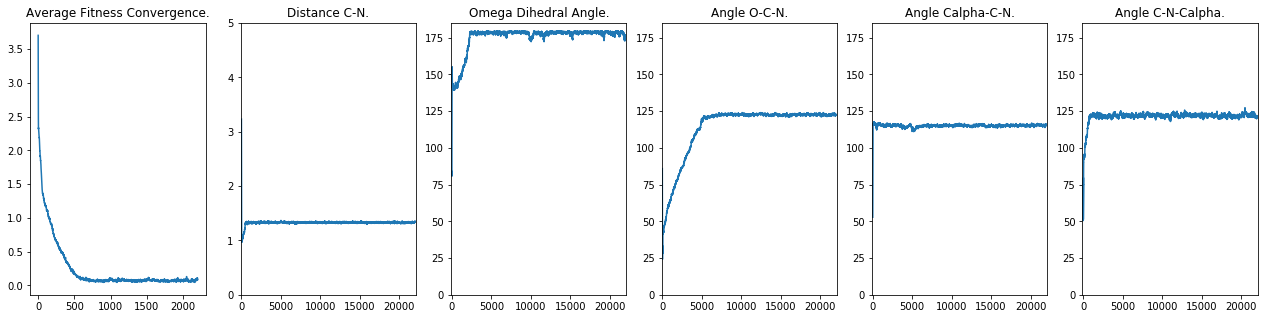

In [34]:
translation, rotation = g.optimize(1200)

The values converged to values around the desired values given by the constraints. However, we can see that they do not converge to the exact value because the desired values are only approximations of the real values that can be achieved.

We are ok with that and consider the Genetic Algorithm ready to be used.

### Generate Tertiary Structure

Once we have a way to calculate the translation and rotation of the next aminoacid in the chain given the previous one, we can implement the routine to generate the tertiary structure of a protein given the primary structure. 

In that routine, we add an amino acid to the chain translating and rotating it based on the values calculated by the genetic algorithm. The values can be calculated for a *trans* peptide bond or a *cis* peptide bond (I considered *cis* for Proline and *trans* for everyone else). Before we add the amino acid to the structure, we also remove the carbonyl OH and the amino H. 

In [18]:
# I'm gonna use only part of the whole molecule because it takes a lot of time
# to predict the translation and rotation of the next aminoacid
# primary_structure = 'TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN'
primary_structure = 'TTCCPS'

In [19]:
def remove_H2O(aminoacid):
    return aminoacid[~aminoacid.atom_name.isin(['OC', 'HC', '1H'])]

def _infer_tertiary_structure(primary_structure, aminoacids_df):
    protein = pd.DataFrame(data=None, columns=['atom_name', 'residue_name', 'residue_seq_number', 'x', 'y', 'z'])    
    previous_aminoacid = None
    
    for i, r in enumerate(primary_structure):
        print('Adding amino acid %s...' % symbol_to_residue_name[r])
        aminoacid = aminoacids_df[aminoacids_df.residue_name == symbol_to_residue_name[r]].copy()
              
        if previous_aminoacid is not None:
            time.sleep(2)
            peptide_group = 'cis' if r == 'P' else 'trans'
            ga = GeneticAlgorithm(dim_populaton=6, n_population=10,
                                  previous_aminoacid=previous_aminoacid, next_aminoacid=aminoacid,
                                  peptide_group=peptide_group)
            translation, rotation = ga.optimize(max_iteration=1200)
            aminoacid = translate(aminoacid, translation)
            aminoacid = rotate(aminoacid, rotation[0], rotation[1], rotation[2])
        else:
            print('This is the first amino acid.')
        
        aminoacid['residue_seq_number'] = str(i)
        
        previous_aminoacid = aminoacid
        
        aminoacid = remove_H2O(aminoacid)
        protein = protein.append(aminoacid, sort=True, ignore_index=True)
        print('Amino acid %s added.\n' % symbol_to_residue_name[r])

    return protein

Adding amino acid THR...
This is the first amino acid.
Amino acid THR added.

Adding amino acid THR...

Optimal Solution:

Tx: 3.28Å, Ty: 1.62Å, Tz: 0.10Å
Ax: 20.27°, Ay: 34.00°, Az: 55.68°

Optimized Metrics:

Distance C-N: 1.335 (1.33)
Omega Dihedral Angle: 179.87 (180.00)
Angle O-C-N: 122.84 (123.50)
Angle Calpha-C-N: 115.01 (116.00)
Angle C-N-Calpha: 122.32 (122.00)



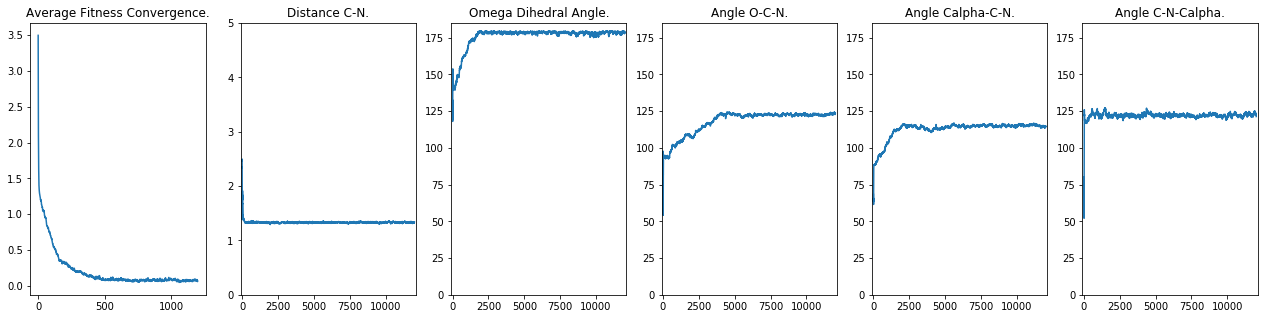

Amino acid THR added.

Adding amino acid CYS...

Optimal Solution:

Tx: 3.67Å, Ty: 5.17Å, Tz: 1.09Å
Ax: 27.55°, Ay: 18.13°, Az: 111.13°

Optimized Metrics:

Distance C-N: 1.325 (1.33)
Omega Dihedral Angle: 178.30 (180.00)
Angle O-C-N: 122.21 (123.50)
Angle Calpha-C-N: 115.81 (116.00)
Angle C-N-Calpha: 123.78 (122.00)



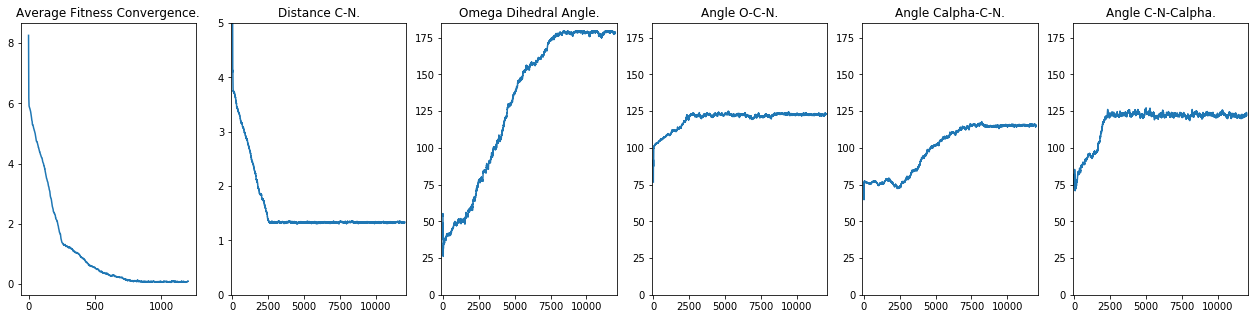

Amino acid CYS added.

Adding amino acid CYS...

Optimal Solution:

Tx: 0.92Å, Ty: 6.92Å, Tz: 2.74Å
Ax: 19.86°, Ay: 198.70°, Az: -6.47°

Optimized Metrics:

Distance C-N: 1.331 (1.33)
Omega Dihedral Angle: 178.04 (180.00)
Angle O-C-N: 121.07 (123.50)
Angle Calpha-C-N: 115.82 (116.00)
Angle C-N-Calpha: 120.71 (122.00)



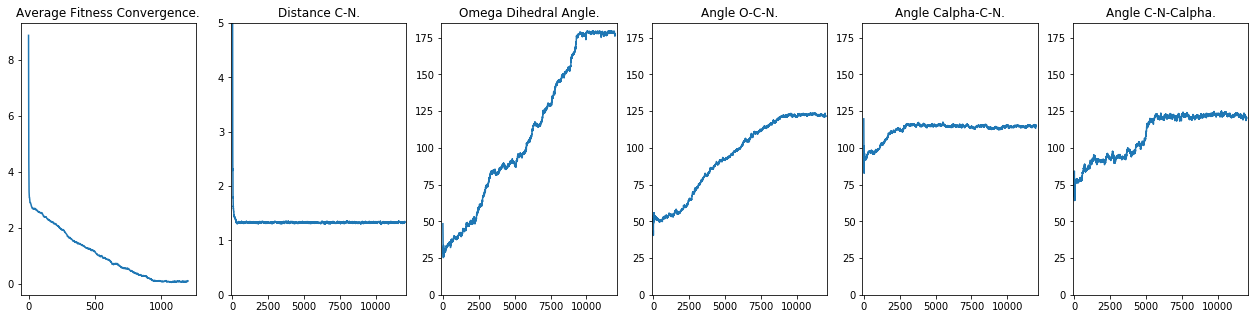

Amino acid CYS added.

Adding amino acid PRO...

Optimal Solution:

Tx: -2.21Å, Ty: 7.01Å, Tz: 4.25Å
Ax: -34.13°, Ay: -128.93°, Az: 25.51°

Optimized Metrics:

Distance C-N: 1.317 (1.32)
Omega Dihedral Angle: 180.00 (180.00)
Angle O-C-N: 121.16 (123.00)
Angle Calpha-C-N: 116.27 (118.00)
Angle C-N-Calpha: 126.22 (126.00)



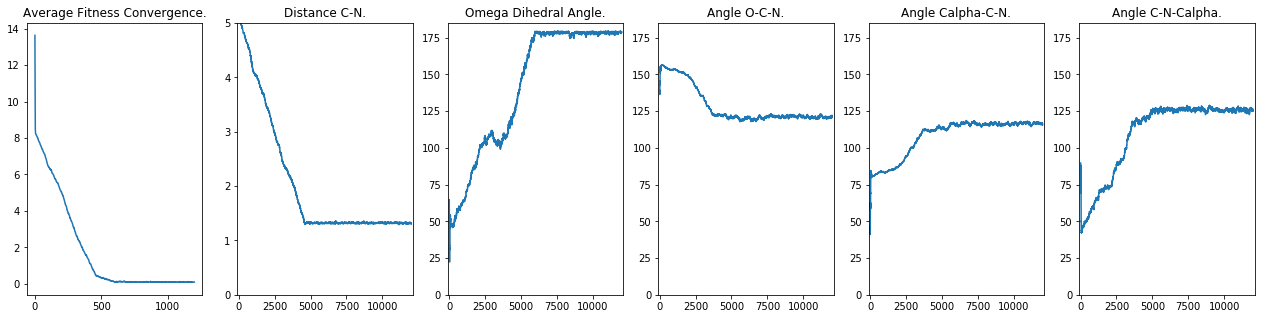

Amino acid PRO added.

Adding amino acid SER...

Optimal Solution:

Tx: -3.08Å, Ty: 11.26Å, Tz: 5.20Å
Ax: 30.67°, Ay: 62.47°, Az: 52.67°

Optimized Metrics:

Distance C-N: 1.333 (1.33)
Omega Dihedral Angle: 178.62 (180.00)
Angle O-C-N: 122.59 (123.50)
Angle Calpha-C-N: 114.87 (116.00)
Angle C-N-Calpha: 124.81 (122.00)



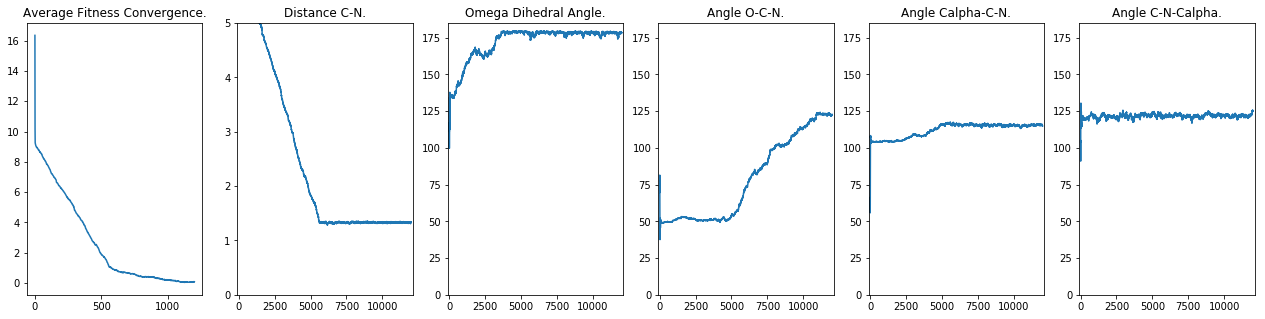

Amino acid SER added.



In [35]:
protein = _infer_tertiary_structure(primary_structure, aminoacids)

We finally have the tertiary structure of the protein.

In [21]:
protein.head(20)

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,THR,0,0.080000,-0.083000,0.000000
1,CA,THR,0,1.539000,-0.033000,0.000000
2,C,THR,0,2.032000,1.394000,0.000000
3,O,THR,0,1.268000,2.339000,0.000000
4,CB,THR,0,2.116000,-0.818000,-1.226000
5,OG1,THR,0,1.743000,-2.188000,-1.162000
6,CG2,THR,0,3.654000,-0.842000,-1.361000
7,2H,THR,0,-0.461000,-1.018000,0.000000
8,HA,THR,0,1.904000,-0.508000,0.929000
9,HB,THR,0,1.691000,-0.378000,-2.154000


# Q2) PHI and PSI angles

**Reference Plane:** The reference plane for both phi and psi contains three atoms: the nitrogen in the amino group, the alpha carbon, and the carbon in the carboxyl group.

**Phi:** The plane for phi contains the carboxyl carbon from the previous segment, plus the amino nitrogen and the alpha carbon from the segment in question. Phi is the angle between this plane and the reference plane.

<h5><center>Phi atoms: C(i-1)-N(i)-Calpha(i)-C(i)</center></h5>

**Psi:** The plane for psi contains the amino nitrogen from the next segment, plus carboxyl carbon and the alpha carbon from the segment in question. Psi is the angle between this plane and the reference plane.

<h5><center>Psi atoms: N(i)-Calpha(i)-C(i)-N(i+1)</center></h5>

Source: https://www.open.edu/openlearn/science-maths-technology/science/biology/proteins/content-section-1.2

In order to calculate Phi and Psi of each amino acid, we implement a routine that calculates the dihedral angle using 4 atoms as described above.

In [22]:
def _infer_phi(c_previous, n_current, c_alpha_current, c_current):
    return calculate_dihedral_angle(c_previous, n_current, c_alpha_current, c_current)


def _infer_psi(n_current, c_alpha_current, c_current, n_next):
    return calculate_dihedral_angle(n_current, c_alpha_current, c_current, n_next)


def infer_phi_psi(protein):
    phi_psi = pd.DataFrame(data=None, columns=['amino', 'phi', 'psi'])    
    previous_aminoacid = None
    
    for i in protein.residue_seq_number.unique():
        current_aminoacid = protein[protein.residue_seq_number == str(i)].copy()
        next_aminoacid = protein[protein.residue_seq_number == str(int(i)+1)].copy() 
        next_aminoacid = next_aminoacid if not next_aminoacid.empty else None
        
        c_previous = previous_aminoacid[previous_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)\
                     if previous_aminoacid is not None else None
        n_current = current_aminoacid[current_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        c_alpha_current = current_aminoacid[current_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
        c_current = current_aminoacid[current_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = next_aminoacid[next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)\
                 if next_aminoacid is not None else None

        
        phi = _infer_phi(c_previous, n_current, c_alpha_current, c_current) if previous_aminoacid is not None else None
        psi = _infer_psi(n_current, c_alpha_current, c_current, n_next) if next_aminoacid is not None else None
        
        previous_aminoacid = current_aminoacid
        
        new_phi_psi = pd.DataFrame(data={'amino': [current_aminoacid.residue_name.iloc[0]], 
                                         'phi': [phi], 
                                         'psi': [psi]})  
        phi_psi = phi_psi.append(new_phi_psi, sort=True, ignore_index=True)

    return phi_psi

Then we run the routine in the 3D protein assembled above.

In [23]:
phi_psi = infer_phi_psi(protein)

In [25]:
phi_psi.head(20)

,amino,phi,psi
0,THR,NaN,-172.609
1,THR,-9.303012,177.361
2,CYS,-101.401693,-178.849
3,CYS,-145.016028,176.289
4,PRO,-55.606046,77.0439
5,SER,-64.986726,None


# Q3) Ramachandran Plot

The Ramachandran Plot is a way to visualize dihedral angles ψ against φ of amino acid residues in protein structure.

We run the Phi and Psi calculation algorithm in the 1CRDN protein of PDB.

In [26]:
ramachandran = infer_phi_psi(molecule)

In [27]:
ramachandran.head()

,amino,phi,psi
0,THR,NaN,147.66
1,THR,-107.832573,144.346
2,CYS,-131.170389,133.291
3,CYS,-118.896523,151.203
4,PRO,-76.181506,-18.9794


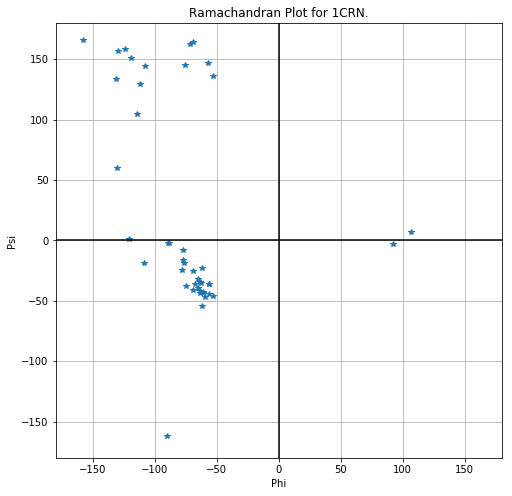

In [37]:
plt.figure(figsize=(8,8))
plt.title('Ramachandran Plot for 1CRN.')
plt.plot(ramachandran.phi, ramachandran.psi, '*')
plt.plot(np.linspace(-180, 180, len(ramachandran.phi)), np.zeros(len(ramachandran.psi)), 'k')
plt.plot(np.zeros(len(ramachandran.phi)), np.linspace(-180, 180, len(ramachandran.psi)), 'k')
plt.xlabel('Phi')
plt.ylabel('Psi')
plt.grid()
plt.axis([-180, 180, -180, 180])
plt.show()

# Q4) Tertiary to Secondary Structure

First of all, let's take a look on the most populated regions in the Ramachandran Plot for Alpha Helix and Beta Sheets based on data from the Protein Data Bank.

**Alpha Helix:** *'As many as 39% of all 237 384 amino acids were found here, in an area just 2% of the Ramachandran plot (-89° < Phi < -39°, -66° < Psi < -16°)'*

**Beta Sheets:** *'The conformations of the amino acids in five of the six groups were surprisingly similar with respect to both the average and values (all within -130° < Phi < -105° and 128° < Psi < 147°) for the first five groups and the standard deviations (15±26°).'*

Source: HOVMOLLER S1, ZHOU T, OHLSON T. *Conformations of amino acids in proteins. Acta Crystallogr D Biol Crystallogr.* 
2002 May;58(Pt 5):768-76. Epub 2002 Apr 26.

In [29]:
alpha_helix_phi_range = (-89, -39)
alpha_helix_psi_range = (-66, -16)

beta_sheet_phi_range = (-130, -105)
beta_sheet_psi_range = (128, 147)

After defining the most populated regions, we can just verify if Phi and Psi of the amino acid is inside the region. If it is inside the Alpha Helix region, we atribute a H to the amino acid and if it is inside the Beta Sheet region, we atribute an S to the amino acid.

In [30]:
def is_between(value, _range):
    return _range[0] < value < _range[1]

def is_alpha_helix(phi, psi):
    is_helix_phi = is_between(phi, alpha_helix_phi_range)
    is_helix_psi = is_between(psi, alpha_helix_psi_range)
    return is_helix_phi and is_helix_phi

def is_beta_sheet(phi, psi):
    is_sheet_phi = is_between(phi, beta_sheet_phi_range)
    is_sheet_psi = is_between(psi, beta_sheet_psi_range)
    return is_sheet_phi and is_sheet_phi

In [31]:
def infer_secondary_structure(phi_psi_df):
    secondary_structure = ''
    for i, row in phi_psi_df.iterrows():
        phi, psi = row.phi, row.psi
        
        if phi is not None and psi is not None:
            if is_alpha_helix(phi, psi):
                secondary_structure += ('H')
            elif is_beta_sheet(phi, psi):
                secondary_structure += ('S')
            else:
                secondary_structure += ('-')
        else:
            secondary_structure += ('-')

    return secondary_structure

In [32]:
secondary_structure = infer_secondary_structure(ramachandran)

In [39]:
print('Primary Structure:')
print('TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN\n')
print('Secondary Structure:')
print(secondary_structure)

Primary Structure:
TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN

Secondary Structure:
-S-SH-HHHHHHHHHHHHH-HHHHHHHHHS-HSSSH-SSHHH--H-


Done!